In [774]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Data Processing 

In [775]:
sales_data = pd.read_csv('Data/sales dataset.csv')
sales_data['salesDate'] = pd.to_datetime(sales_data['salesDate'], infer_datetime_format=True)
selected_columns1 =['salesAmount', 'salesDate']
sales_data = sales_data[selected_columns1]
##########################################################################
expenses_data = pd.read_csv('Data/expenses dataset.csv')
expenses_data['expenseDate'] = pd.to_datetime(expenses_data['expenseDate'], infer_datetime_format=True)
selected_columns =['expenseAmount', 'expenseDate']
expenses_data = expenses_data[selected_columns]
##########################################################################
# print('Shape of expenses data', expenses_data.shape)
# print('Shape of sales data', sales_data.shape)

In [776]:
# The function groups either the expense or sales data into the monthly series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupMonth(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Amount'] = df.iloc[:,0]
    monthly = df.groupby(['Year','Month'])['Amount'].sum().reset_index()
    return monthly

# The function groups either the expense or sales data into the daily series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupDay(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Day'] = df.iloc[:,1].dt.day
    df['Amount'] = df.iloc[:,0]
    daily = df.groupby(['Year','Month','Day'])['Amount'].sum().reset_index()
    return daily

def monthlyToSingleDate(df, Year, Month):
    df['date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))
    df = df.drop(['Year','Month',], axis=1)
    df = df.set_index('date')
    return df

def dailyToSingleDate(df,Year, Month, Day):
        df['date'] = pd.to_datetime(df[['Year','Month','Day']])
        df = df.drop(['Year','Month','Day'], axis=1)
        df = df.set_index('date')
        return df

In [777]:
sd = groupDay(sales_data)
ed = groupDay(expenses_data)
em = groupMonth(expenses_data)
sm = groupMonth(sales_data)

daily_sales = dailyToSingleDate(sd, sd['Year'], sd['Month'], sd['Day'])
daily_expenses = dailyToSingleDate(ed, ed['Year'], ed['Month'], ed['Day'])
monthly_expenses = monthlyToSingleDate(em, em['Year'], em['Month'])
monthly_sales = monthlyToSingleDate(sm, sm['Year'], sm['Month'])

In [778]:
dailySales = daily_sales[705:]    #705 for the removal of irrelevant data points
dailyExpenses = daily_expenses[890:]  #890 for the removal of irrelevant data points
monthlySales = monthly_sales
monthlyExpenses = monthly_expenses

In [779]:
print(len(monthlyExpenses), len(monthlySales))
print(len(dailyExpenses), len(dailySales))

43 38
182 236


In [780]:
category1 = dailySales
category2 = dailyExpenses
category3 = monthlySales
category4 = monthlyExpenses
category = category4

# Remove Outliers

In [781]:
def remove_outliers_zscore(data, threshold=4):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    filtered_data = data[(z_scores < threshold)]
    return filtered_data

filteredCategory = remove_outliers_zscore(category)
category = filteredCategory
category = category.tail(20)

C:\Users\Berlin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [782]:
category = pd.DataFrame(category['Amount'])
category.reset_index(inplace=True)
Category = category

# Adding Lagged Variables

In [783]:
lags = [1,2,3,4]
for lag in lags:
    category[f'lag{lag}'] = category['Amount'].shift(lag)
category.dropna(inplace=True)
selected_columns = ['Amount', 'lag1', 'lag2', 'lag3','lag4']
category = category[selected_columns]
category

,Amount,lag1,lag2,lag3,lag4
4,2951285.0,4269108.0,5117140.0,4532500.0,2448500.0
5,3023914.0,2951285.0,4269108.0,5117140.0,4532500.0
6,3484350.0,3023914.0,2951285.0,4269108.0,5117140.0
7,2935800.0,3484350.0,3023914.0,2951285.0,4269108.0
8,2462150.0,2935800.0,3484350.0,3023914.0,2951285.0
9,4652250.0,2462150.0,2935800.0,3484350.0,3023914.0
10,1050750.0,4652250.0,2462150.0,2935800.0,3484350.0
11,546350.0,1050750.0,4652250.0,2462150.0,2935800.0
12,1654105.0,546350.0,1050750.0,4652250.0,2462150.0
13,2195350.0,1654105.0,546350.0,1050750.0,4652250.0


# Adding Moving Average

In [784]:
# category['moving_avg'] = category[['lag1', 'lag2', 'lag3', 'lag4']].mean(axis=1).rolling(window=window_size).mean()
# category.dropna(inplace=True)
# category

# Train - Test Split

In [785]:
X = category.drop(category.columns[0], axis=1)
y = category['Amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model Selection

In [786]:
degree = 3
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

# Normalization

In [787]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.fit_transform(X_test_poly)

# PCA

In [788]:
n_components = len(lags)
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

In [789]:
model = LinearRegression()
model.fit(X_train_pca, y_train)

LinearRegression()

In [790]:
# with open('dailySales.pk1', 'wb') as f:
#     pickle.dump(rf_regressor, f)

In [791]:
# with open('dailyExpenses.pk1', 'wb') as f:
#     pickle.dump(model2, f)
# result = model2.fit()
# print(result.summary())

In [792]:
# with open('monthlyExpenses.pk1', 'wb') as f:
#     pickle.dump(rf_regressor, f)
# Takes 3 target lags

# Evaluate Model

In [793]:
y_pred = model.predict(X_train_pca)

In [794]:
mse = mean_squared_error(y_train, y_pred)
rmse =  np.sqrt(mean_squared_error(y_train, y_pred))

print(f'Mean Squared Error : {mse}')
print(f'Root Mean Squared Error : {rmse}')

Mean Squared Error : 856031984995.6323
Root Mean Squared Error : 925219.9657355176


# Make Time Series Predictions

In [795]:
X_test

,lag1,lag2,lag3,lag4
16,1549450.0,1529350.0,2195350.0,1654105.0
17,2304875.0,1549450.0,1529350.0,2195350.0
18,3404500.0,2304875.0,1549450.0,1529350.0
19,2553430.0,3404500.0,2304875.0,1549450.0


In [796]:
# future_timestamp = pd.Timestamp('2023-11-10')
# future_timestamp_numeric = future_timestamp.timestamp()
# future_data_poly = poly_features.transform([[future_timestamp_numeric]])
# future_data_scaled = scaler.transform(future_data_poly)
# forecasted = model.predict(future_data_scaled)
# print(f'Forecasted Sales for {future_timestamp}:{forecasted[0]}')

In [797]:
y_pred

array([2607877.48232653, 3482275.31519058, 3298841.27771394,
       2514322.11320153, 2143191.94320659, 2304541.44459937,
       2468358.81848923, 1714004.61943154, 2482265.34385499,
       1952362.45244756, 1502990.73103756, 1564072.45850057])

In [798]:
index_start = 4
index = range(index_start, index_start + len(y_pred))
df = pd.DataFrame(y_pred, index=index, columns=['Values'])

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

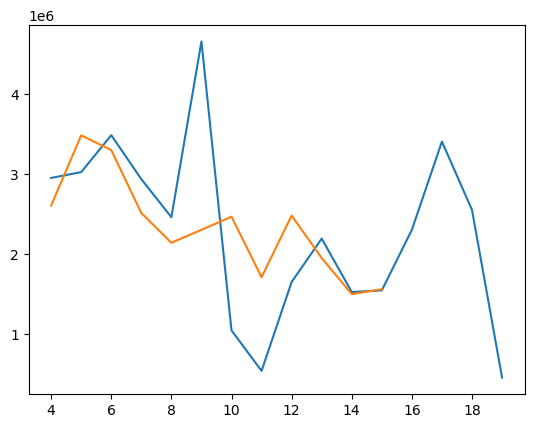

In [799]:
plt.plot(Category['Amount'], label='Original Data')
plt.plot(df)
plt.xlabel